<a href="https://colab.research.google.com/github/ris0801/Generalization-DeepLearning/blob/main/AdvancedProject_Figure1_CIFAR10_PaperCNNArchitecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##CNN architecture as mentioned in paper

In [39]:
class SimpleCNNWithHooks(nn.Module):
    def __init__(self):
        super(SimpleCNNWithHooks, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(200)

        self.conv2 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(200)

        # Fully connected layers
        self.fc1 = nn.Linear(200 * 7 * 7, 384)
        self.bn3 = nn.BatchNorm1d(384)

        self.fc2 = nn.Linear(384, 192)
        self.bn4 = nn.BatchNorm1d(192)

        self.fc3 = nn.Linear(192, 10)

        self.activations = {}

    def forward(self, x):

        x = x[:, :, 2:-2, 2:-2]

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        # Save activations
        self.activations['conv1'] = x

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        # Save activations
        self.activations['conv2'] = x

        x = x.view(-1, 200 * 7 * 7)

        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


#Working with CIFAR10 data

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [42]:
def estimated_p_correct(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct[batch_idx * loader.batch_size:batch_idx * loader.batch_size + len(data)] = pred.eq(target).cpu().numpy().astype(int)
    return correct

###Function for visulazing the weights of first layer

In [43]:
def visualize_weights(weights, img_dim=(8, 8), n_rows=5, n_cols=5, channel_idx=0):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i][j]

            weight = weights[i * n_cols + j].detach().cpu().numpy()
            weight = weight.reshape(32, 8, 8)[channel_idx]

            weight = (weight - weight.min()) / (weight.max() - weight.min())

            ax.imshow(weight, cmap='gray')
            ax.axis('off')

    plt.show()

In [44]:
num_sample_points = 1000

In [45]:
num_initializations = 25
all_p_corrects = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(train_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(train_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects += estimated_p_correct(model, subset_loader)


all_p_corrects /= num_initializations


In [46]:
sorted_p_correct = np.sort(all_p_corrects)

##Feature visualization

In [48]:
def visualize_feature_maps(activation, num_columns=6):

    num_kernels = activation.size(1)
    num_rows = int(np.ceil(num_kernels / num_columns))
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_columns):
            if i * num_columns + j < num_kernels:
                ax = axes[i, j]
                ax.imshow(activation[0][i * num_columns + j].detach().cpu().numpy(), cmap='viridis')
                ax.axis('off')
            else:
                axes[i, j].remove()

    plt.show()

In [49]:
model.eval()

SimpleCNNWithHooks(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9800, out_features=384, bias=True)
  (bn3): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (bn4): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=192, out_features=10, bias=True)
)

In [50]:
# Get one batch of CIFAR10 images to visualize feature maps
images, labels = next(iter(train_loader))
images = images.to(device)

In [51]:
# Forward pass to get the activations
with torch.no_grad():
    output = model(images)

Feature maps for layer: conv1


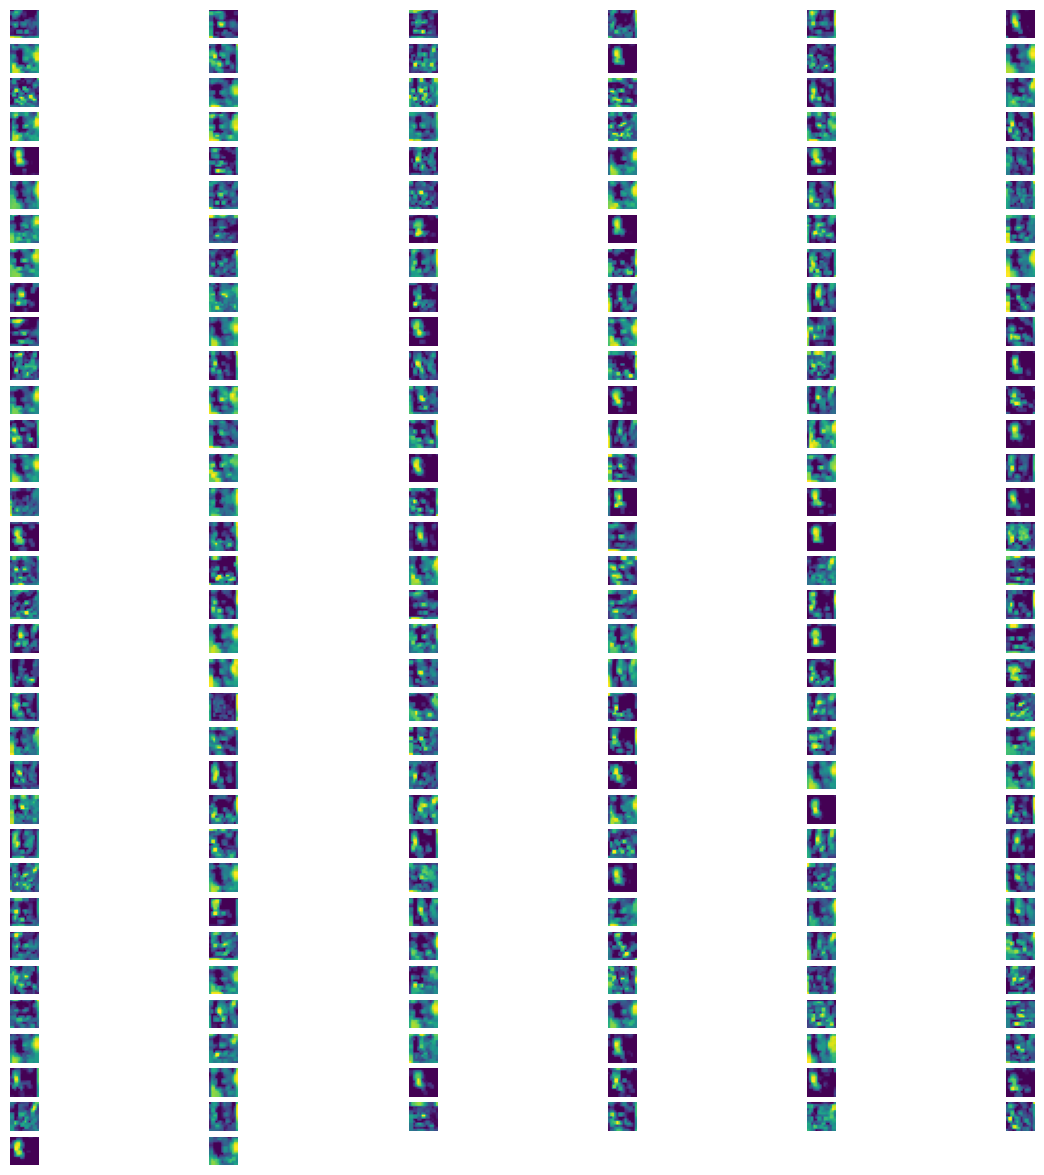

Feature maps for layer: conv2


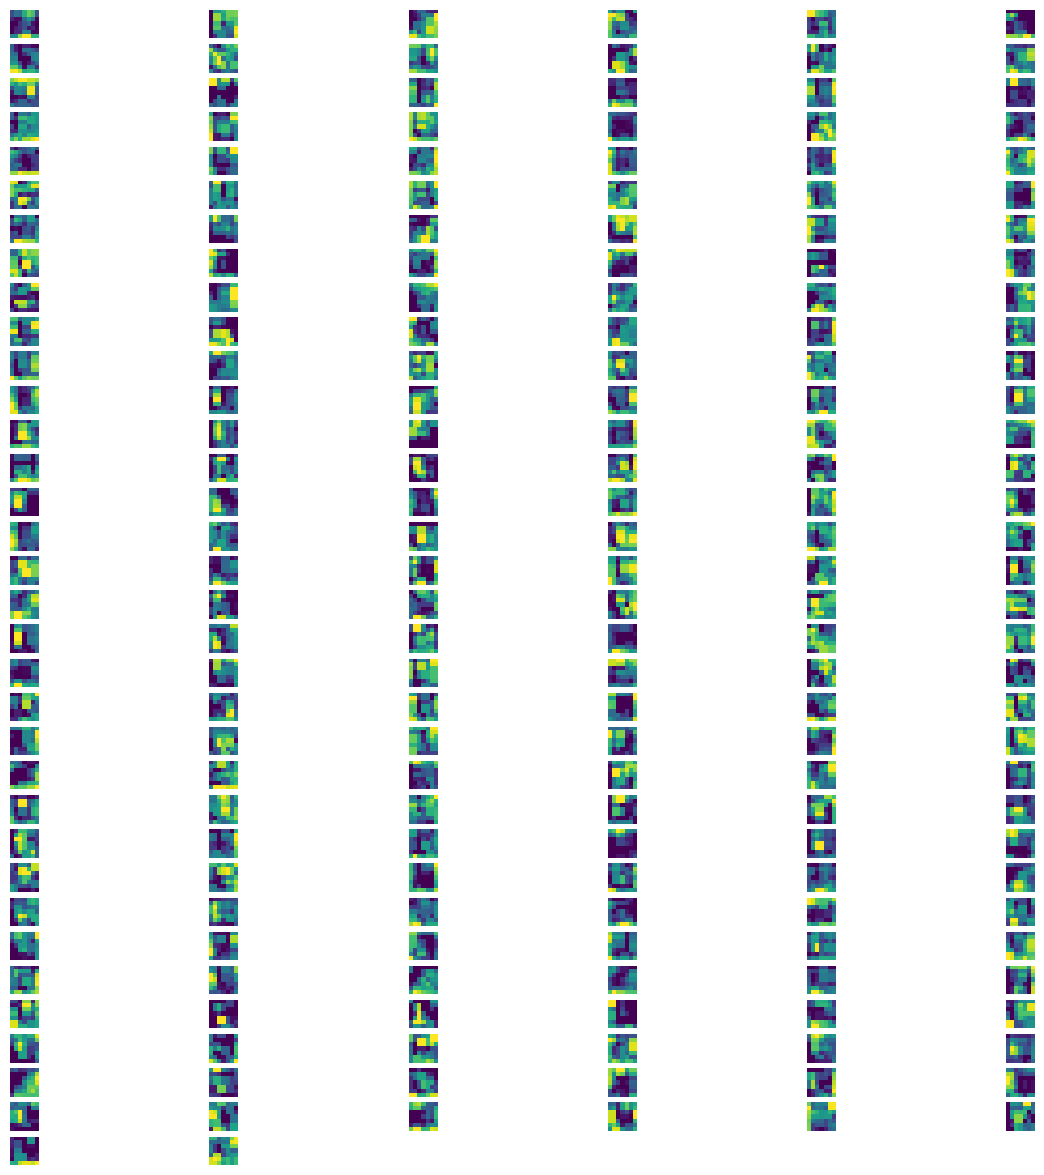

In [52]:
# Now, visualize the feature maps for each convolutional layer
for layer_name, activation in model.activations.items():
    print(f"Feature maps for layer: {layer_name}")
    visualize_feature_maps(activation)

The activations appear to be varied, with different colors (indicative of activation values) spread across the visualization. This suggests that the convolution layer is detecting various features from the actual data

In [53]:
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [54]:
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


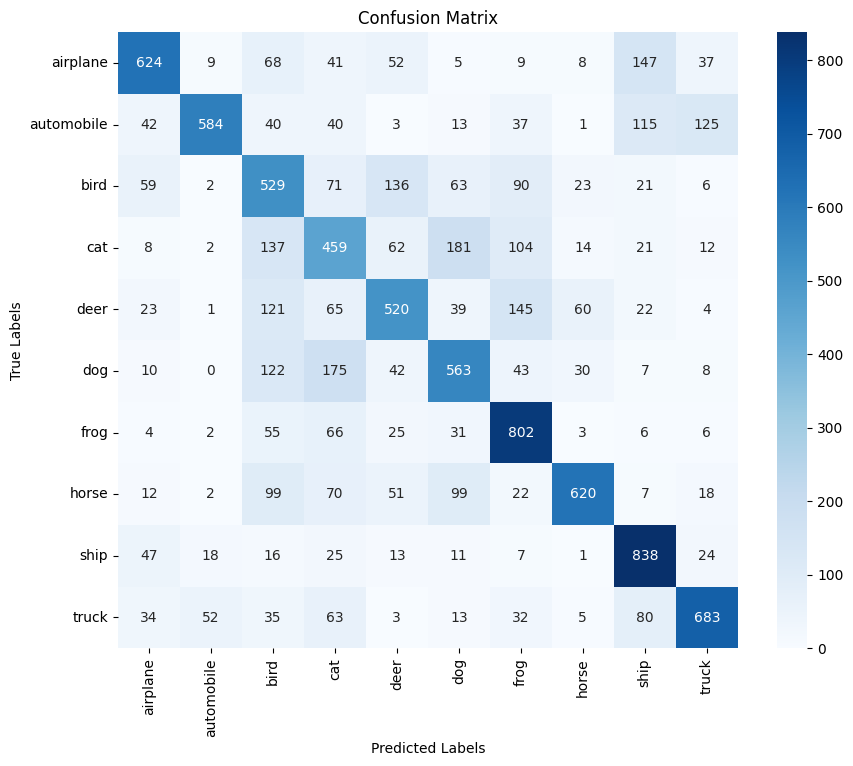

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred, y_true = get_predictions(model, val_loader)

cm = confusion_matrix(y_true, y_pred)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

###Working with radomized inputs

In [56]:
# randX: Replace the input with Gaussian noise
# Convert the dataset to the expected format and then create randX_data
formatted_data = np.transpose(train_dataset.data, (0, 3, 1, 2))  # [N, 3, 32, 32]
randX_data = torch.randn_like(torch.tensor(formatted_data, dtype=torch.float)) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, torch.tensor(train_dataset.targets))
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [57]:
num_initializations = 25
all_p_corrects_randx = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randX_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randX_data)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randX_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randx += estimated_p_correct(model, subset_loader)

all_p_corrects_randx /= num_initializations

In [58]:
sorted_p_correct_randx = np.sort(all_p_corrects_randx)

In [60]:
images, labels = next(iter(randX_loader))
images = images.to(device)

In [61]:
with torch.no_grad():
    output = model(images)

Feature maps for layer: conv1


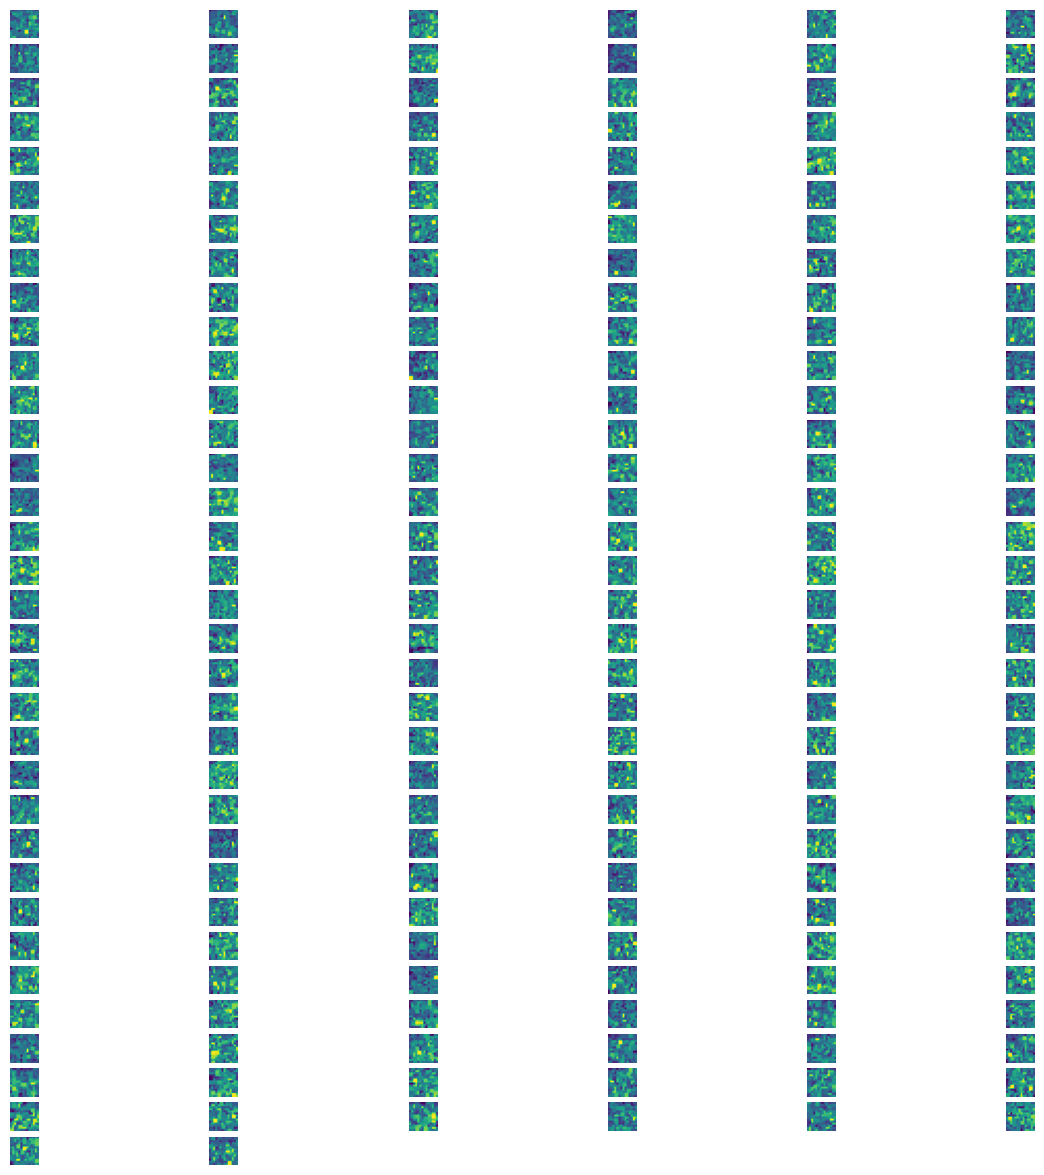

Feature maps for layer: conv2


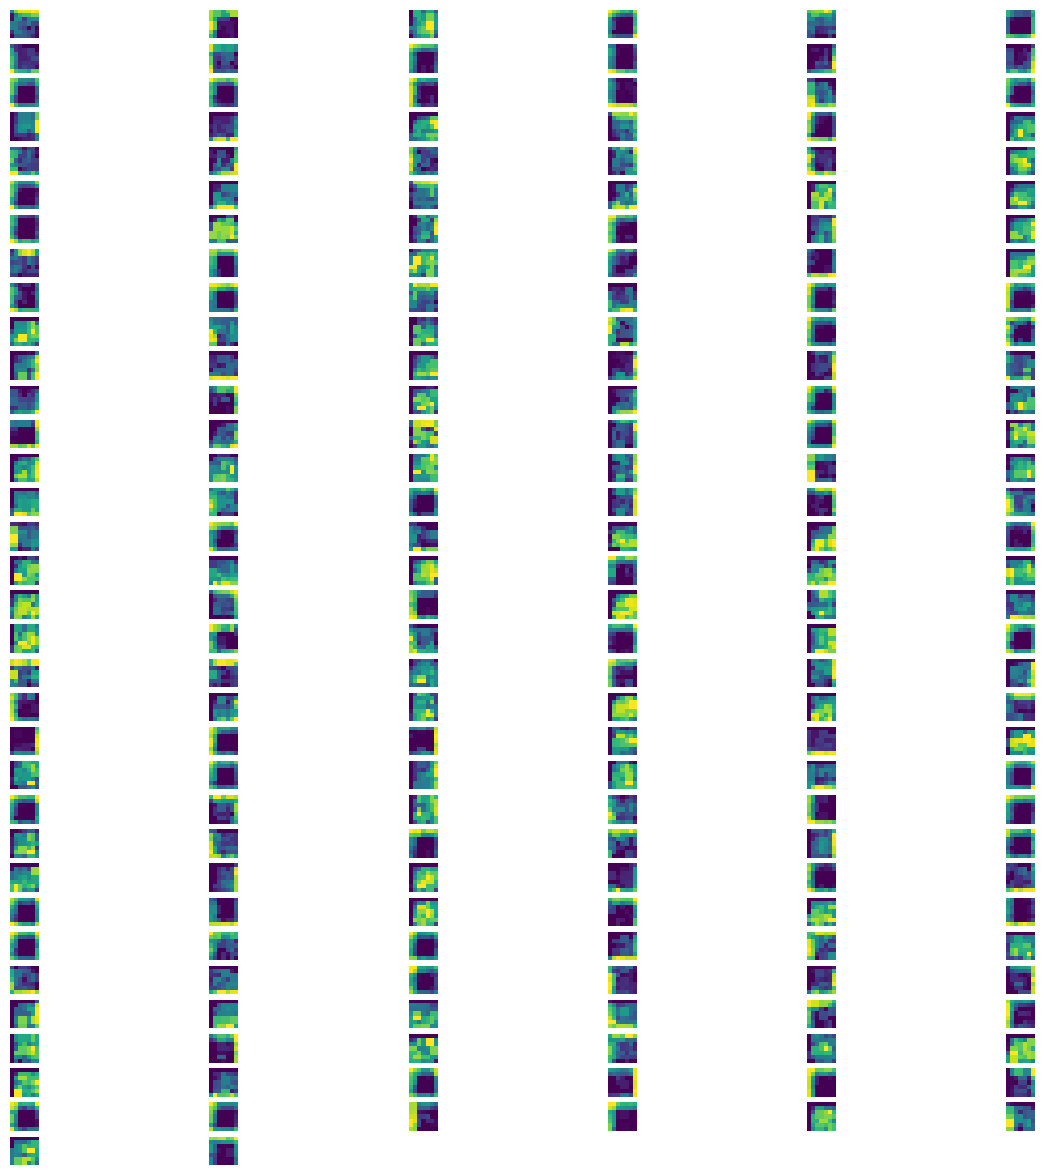

In [62]:
for layer_name, activation in model.activations.items():
    print(f"Feature maps for layer: {layer_name}")
    visualize_feature_maps(activation)

The activations look more uniform compared to the actual data. This is expected since randomized inputs lack structured patterns that the model's filters are designed to detect.

In [63]:
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


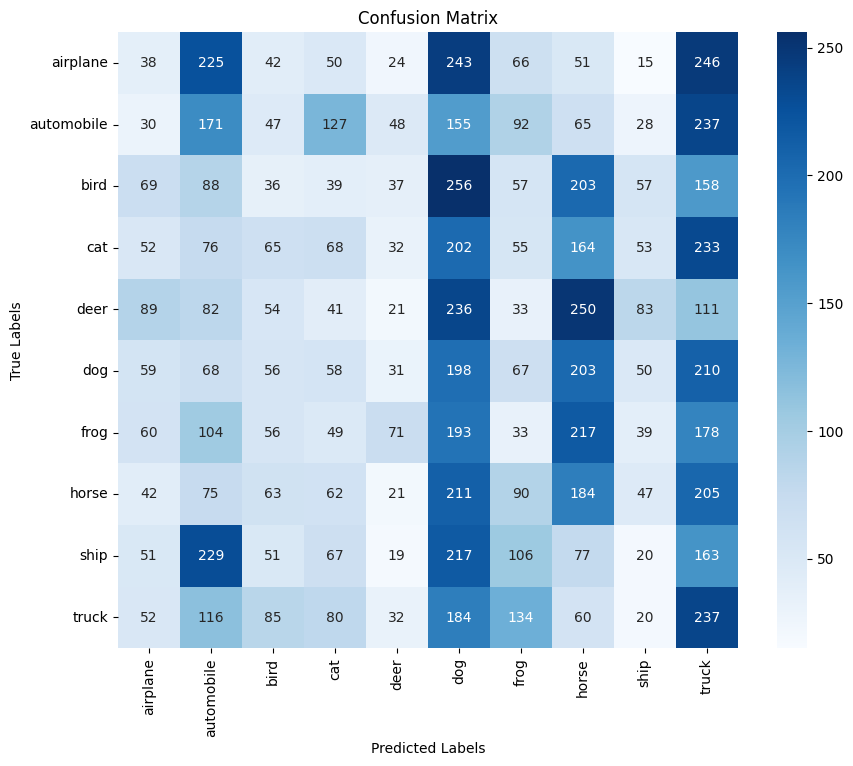

In [64]:
# Get predictions
y_pred, y_true = get_predictions(model, val_loader)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##Working with randomized labels

In [65]:
# Convert the numpy data to a tensor and transpose to the correct shape
formatted_data_tensor = torch.tensor(np.transpose(train_dataset.data, (0, 3, 1, 2)), dtype=torch.float) / 255.

# Generate random labels for the data
randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)

randY_dataset = torch.utils.data.TensorDataset(formatted_data_tensor, randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [66]:
num_initializations = 25
all_p_corrects_randy = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNNWithHooks().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for data, target in randY_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randY_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randY_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randy += estimated_p_correct(model, subset_loader)

all_p_corrects_randy /= num_initializations

In [67]:
# # Visualizing the weigths of the first layer
# weights = model.fc1.weight
# visualize_weights(weights)

In [68]:
sorted_p_correct_randy = np.sort(all_p_corrects_randy)

In [69]:
images, labels = next(iter(randY_loader))
images = images.to(device)

In [70]:
with torch.no_grad():
    output = model(images)

Feature maps for layer: conv1


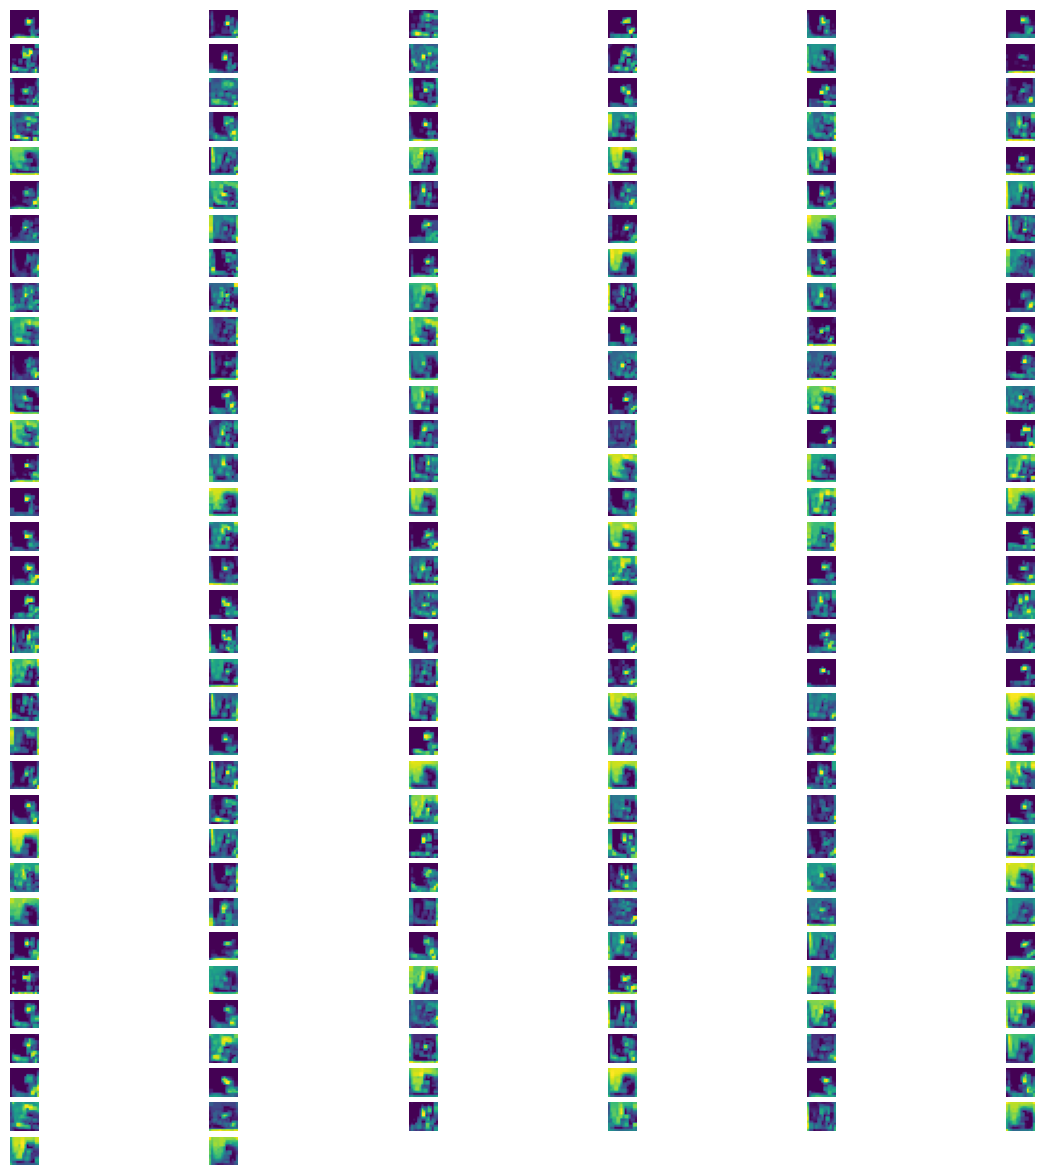

Feature maps for layer: conv2


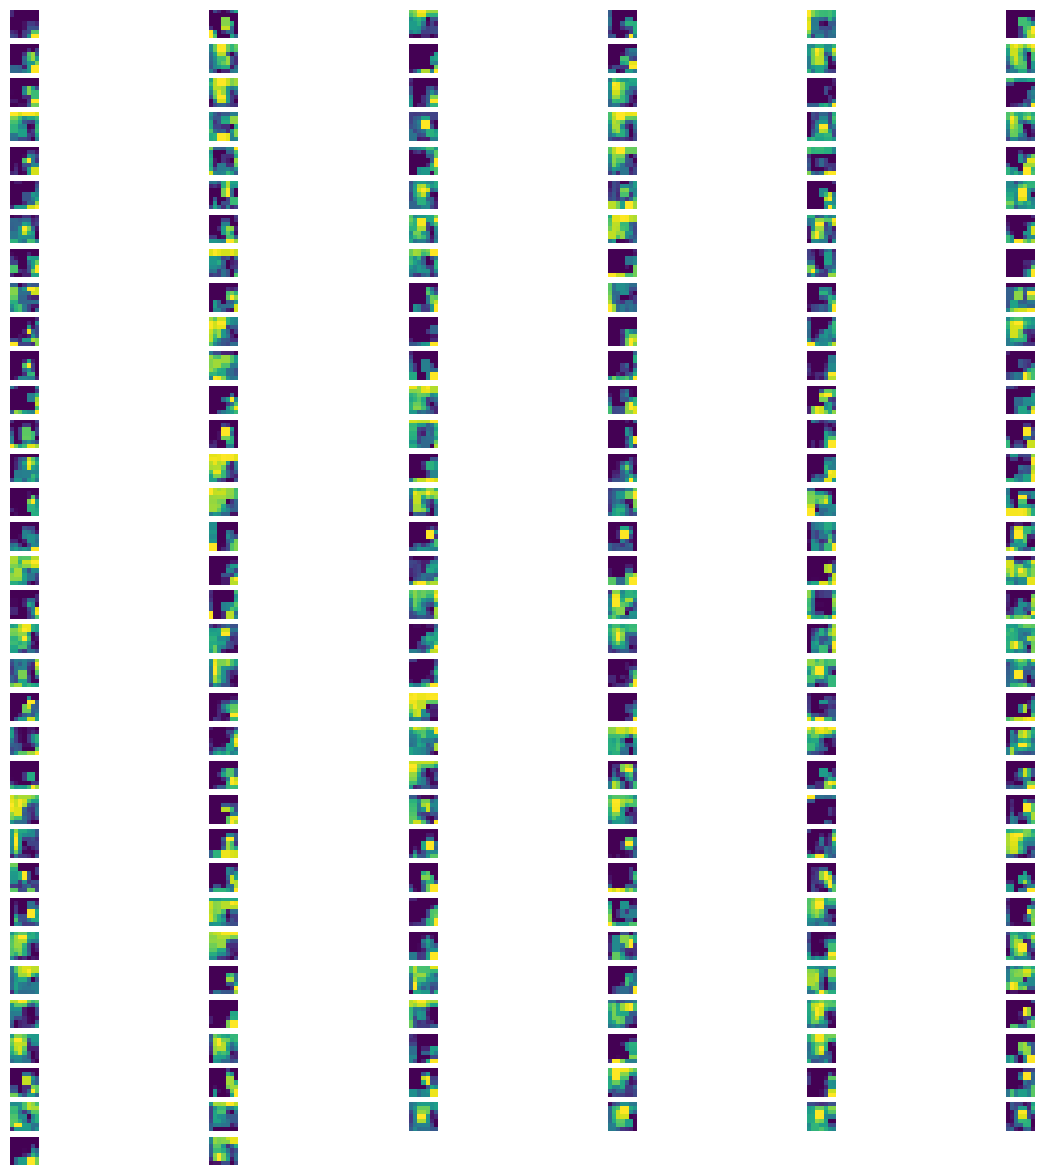

In [71]:
# Now, visualize the feature maps for each convolutional layer
for layer_name, activation in model.activations.items():
    print(f"Feature maps for layer: {layer_name}")
    visualize_feature_maps(activation)

In [72]:
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


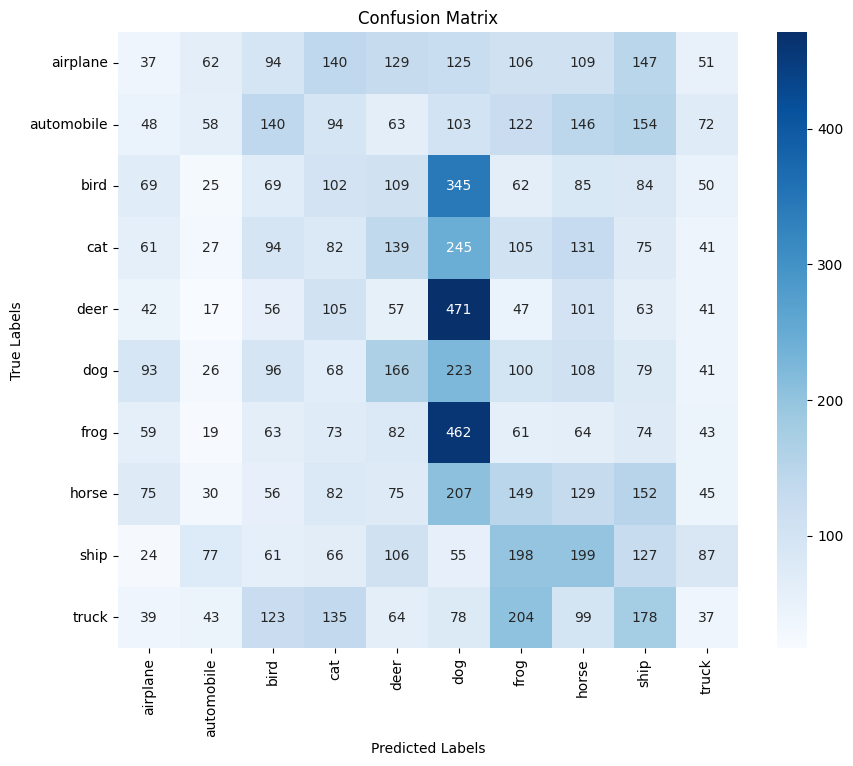

In [73]:
# Get predictions
y_pred, y_true = get_predictions(model, val_loader)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

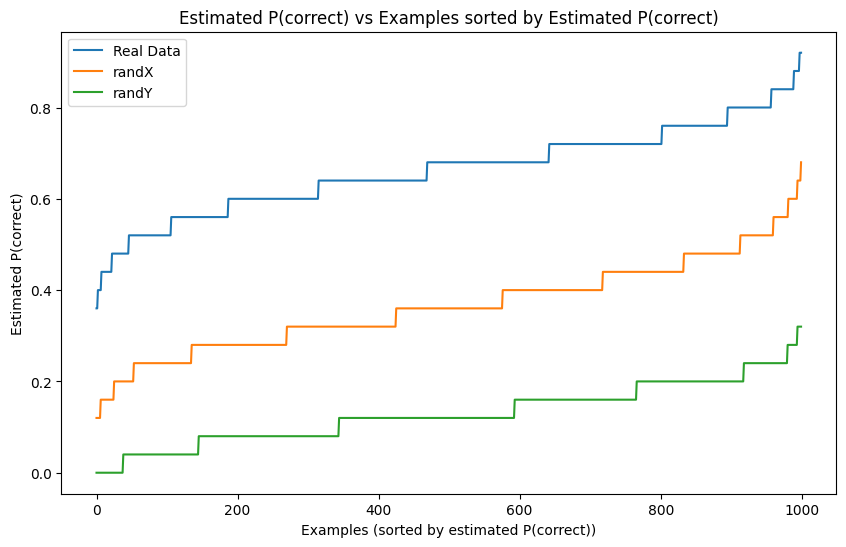

In [74]:
plt.figure(figsize=(10,6))

# Plotting each dataset
plt.plot(sorted_p_correct, label="Real Data")
plt.plot(sorted_p_correct_randx, label="randX")
plt.plot(sorted_p_correct_randy, label="randY")

# Setting labels, title, and legend
plt.xlabel('Examples (sorted by estimated P(correct))')
plt.ylabel('Estimated P(correct)')
plt.legend()
plt.title("Estimated P(correct) vs Examples sorted by Estimated P(correct)")

# Display the plot
plt.show()
